# Tutorial: Fermi GBM Trigger Data

Adapted from "Quicklook Trigger Data" in the Fermi GBM Data Tools documentation and "Fermi GBM Trigger Data" in the Fermi Gamma-ray Data Tools documentation. 

So you’re interested in using trigger data (TRIGDAT)? You must be a glutton for punishment!

In all seriousness, TRIGDAT was designed so that it contains the minimum amount of data required for rapid on-ground characterization and localization of triggers. To that purpose, the TRGIDAT contains 8-channel pre-binned lightcurve data for each of the 14 detectors along with spacecraft position and attitude information for each bin. The lightcurve data, though, has multiple resolutions. There are “background” time bins of 8.124 seconds duration from the start of the trigger data to just before trigger time, and then about 50 seconds after the trigger time through the rest of the data. In between the two segments of “background” bins, there are 1.024 second duration bins, and in a very short window around the trigger time, there are overlapping bins of width 256 and 64 milliseonds. This design enables a preliminary rapid analysis for long duration triggers that can last from several tens of seconds down sub-second duration triggers. The fact that the different bin timescales are overlapping creates difficulty if you want to make lightcurve plots, but the `Trigdat` class solves this problem for you.

In this tutorial, we will go through an example of how to use the Fermi Gamma-Ray Tools (GDT) toolkit as well as the core GDT toolkit to plot the lighcurves of gamma-ray bursts and the positional data of the Fermi instrument using trigger data from the Fermi Gamma-ray Burst Monitor.

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import gdt.missions.fermi 
import gdt.core 

Let's start by downloading and opening a TRIGDAT file. We can use the `TriggerFtp` class from the GDT Fermi toolkit to download data from NASA's High Energy Astrophysics Science Archive Research Center (HEASARC) archive, and the `Trigdat` class from the same toolkit to open and read the data. We will use event **170101116** as our example event for the rest of this tutorial.

In [2]:
from gdt.missions.fermi.gbm.finders import TriggerFtp
from gdt.missions.fermi.gbm.trigdat import Trigdat
from gdt.core import data_path

# initialize TriggerFtp to pull data from event 170101116
trig_finder = TriggerFtp('170101116')

# download trigger data file
trig_finder.get_trigdat(download_dir=data_path.joinpath('170101116'))

# open the downloaded data
trigdat = Trigdat.open(data_path.joinpath('170101116/glg_trigdat_all_bn170101116_v01.fit'))

print(trigdat)

Output()

<Trigdat: glg_trigdat_all_bn170101116_v01.fit;
 trigtime=504931642.87; triggered detectors=['n9', 'na', 'nb']>


There is a ton of metadata and extensions related to how the trigger was processed onboard the spacecraft: the trigger timescale and rates in each detector, the simple background rates that are used onboard the spacecraft, and the onboard trigger classification and localization information. We really won’t delve into all of that other than to point out that it exists and is accessible through the Trigdat attributes and methods. As for the extensions:

In [3]:
# display the extensions for trigdat
trigdat.headers.keys()

['PRIMARY', 'TRIGRATE', 'BCKRATES', 'OB_CALC', 'MAXRATES', 'EVNTRATE']

The pertinent data we want to use is in the ‘EVNTRATE’ extension. Since this contains the 8-channel lightcurve for each of the detectors, we can extract the data for a detector and return it as a PHAII object:

In [4]:
# convert the trigger data into a phaii object with data for NaI 0
phaii = trigdat.to_phaii('n0')
type(phaii)

gdt.missions.fermi.gbm.phaii.GbmPhaii

Once extracted, it has the full capabilities of the `GbmPhaii` class. You can also retrieve the sum of the detectors. When summing the data, the exposures from different detectors are averaged.

In [5]:
# show which detectors were triggered in the event and group them together
trig_dets = trigdat.triggered_detectors
print(trig_dets)

# sum the triggered detectors
summed_phaii = trigdat.sum_detectors(trig_dets)

['n9', 'na', 'nb']


And then you can plot the lightcurve using the `Lightcurve` class from the GDT Core toolkit.

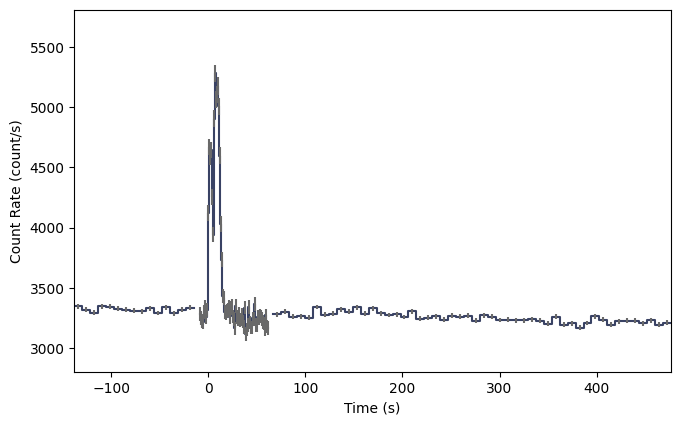

In [6]:
from gdt.core.plot.lightcurve import Lightcurve

# convert the summed data from the triggered detectors into a lightcurve and plot it
lcplot = Lightcurve(data=summed_phaii.to_lightcurve())

From the plot you can easily see where the 8 second timescale changes to the 1 second timescale and then back to the 8 second timescale. By default, you can retrieve the 8 second and 1 second data for the lightcurve, but what if you want to retrieve the 256 millisecond or 64 millisecond timescales? You can do that by giving `to_phaii()` or `sum_detectors()` a timescale keyword:

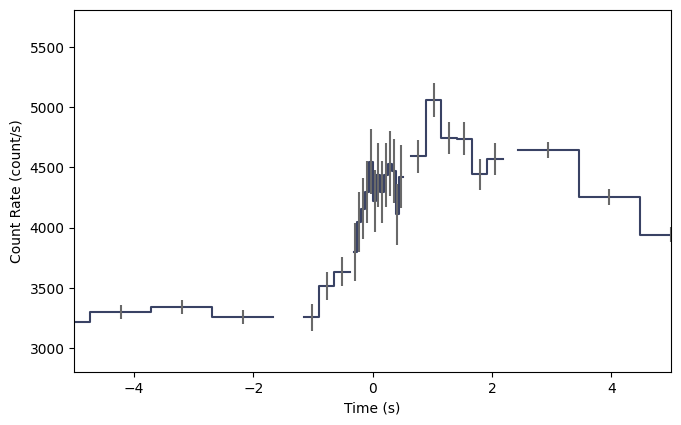

In [7]:
# retrieve all timescales 64 ms up to 8 s
# possible options for timescale is 64, 256, or 1024
summed_phaii = trigdat.sum_detectors(trig_dets, timescale=64)

# plot lightcurve with new timescale and zoom in 
lcplot = Lightcurve(data=summed_phaii.to_lightcurve())
lcplot.xlim = (-5.0, 5.0)

As you can see, all timescales are now plotted and merged into a single lightcurve. The 64 ms option will return all timescales at >= 64 ms, while the 256 ms option will return all timescales >= 256 ms. This lightcurve doesn’t look particularly pretty because it’s a long-duration GRB, but short GRBs show up very nicely on the 64 and 256 ms timescales.

As mentioned earlier, TRIGDAT also contains spacecraft position history and attitude information. This means that nearly everything we can do with standard position history data can alse be done with TRIGDAT. For example, we can determine where the detectors were pointing at the time of the trigger:

In [8]:
from gdt.missions.fermi.time import *

# initialize time class with the trigger time
time = Time(trigdat.trigtime, format='fermi')

# the spacecraft frame at trigger time
frame = trigdat.poshist.at(time)

# get n9 pointing in the ICRS frame
trigdat.poshist.detectors.n9.skycoord(frame).icrs

<SkyCoord (ICRS): (ra, dec) in deg
    [(68.87778267, 17.76359435)]>

We can also make a sky plot using the `EquatorialPlot` class. This shows the pointings of all the detectors (in gray), the region of the sky blocked by Earth (in blue), the sun (marked by a yellow symbol), and the galactic plane (marked by a dark gray line). 

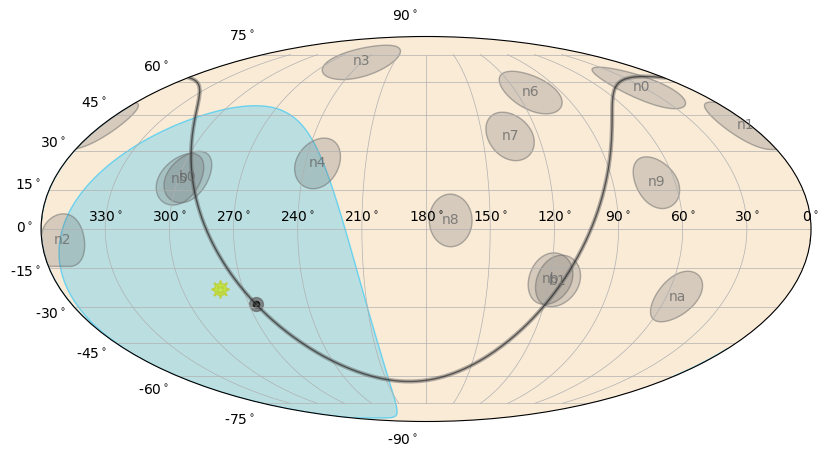

In [9]:
from gdt.core.plot.sky import EquatorialPlot

# plot detector pointings in the sky at trigger time
eqplot=EquatorialPlot()
eqplot.add_frame(trigdat.poshist.at(time))

We can also make an orbital plot using the `FermiEarthPlot` class. This shows a heatmap of the McIlwain L-parameter, the South Atlantic Anomaly (in red), and a marker of the Fermi instrument's position at the trigger time with a segment of its orbit during our observed time range (marked by a light gray line).

AttributeError: 'Colorbar' object has no attribute 'draw_all'

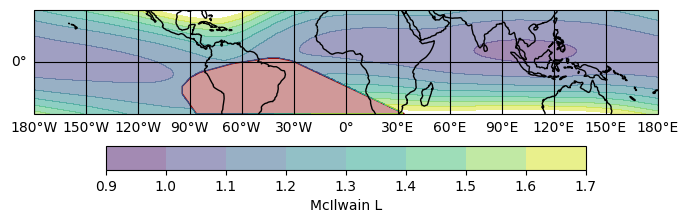

In [10]:
from gdt.missions.fermi.plot import FermiEarthPlot
from gdt.missions.fermi.gbm.saa import GbmSaa

# plot fermi orbital location at trigger time 
earthplot = FermiEarthPlot(saa=GbmSaa(),mcilwain=True)
earthplot.add_spacecraft_frame(trigdat.poshist, trigtime=time)

Congratulations, you’ve completed the lesson on trigger data!